In [ ]:
## our C-lstm and LSTM model is build based on the code by Kent, I cited his code on my paper and the link of his code is shown below
## https://github.com/laxmimerit/Human-Activity-Recognition-Using-Accelerometer-Data-and-CNN

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D,LSTM,MaxPooling2D,Reshape,Input
from tensorflow.keras.optimizers import Adam
print (tf.__version__)

2.3.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

#### Load the Dataset 

In [3]:
#Dataset can't be read directly from pd.read_csv,because there is empty rows in the dataset.
file = open('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [4]:
processedList

[['33', 'Jogging', '49105962326000', '-0.6946377', '12.680544', '0.50395286'],
 ['33', 'Jogging', '49106062271000', '5.012288', '11.264028', '0.95342433'],
 ['33', 'Jogging', '49106112167000', '4.903325', '10.882658', '-0.08172209'],
 ['33', 'Jogging', '49106222305000', '-0.61291564', '18.496431', '3.0237172'],
 ['33', 'Jogging', '49106332290000', '-1.1849703', '12.108489', '7.205164'],
 ['33', 'Jogging', '49106442306000', '1.3756552', '-2.4925237', '-6.510526'],
 ['33', 'Jogging', '49106542312000', '-0.61291564', '10.56939', '5.706926'],
 ['33', 'Jogging', '49106652389000', '-0.50395286', '13.947236', '7.0553403'],
 ['33', 'Jogging', '49106762313000', '-8.430995', '11.413852', '5.134871'],
 ['33', 'Jogging', '49106872299000', '0.95342433', '1.3756552', '1.6480621'],
 ['33', 'Jogging', '49106982315000', '-8.19945', '19.57244', '2.7240696'],
 ['33', 'Jogging', '49107092330000', '1.4165162', '5.7886477', '2.982856'],
 ['33', 'Jogging', '49107202316000', '-1.879608', '-2.982856', '-0.2996

In [5]:
activities = ['user', 'activity', 'time', 'x', 'y', 'z']

In [6]:
data = pd.DataFrame(data = processedList, columns = activities)
data.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [7]:
data.shape

(343416, 6)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      343416 non-null  object
 1   activity  343416 non-null  object
 2   time      343416 non-null  object
 3   x         343416 non-null  object
 4   y         343416 non-null  object
 5   z         343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB


In [9]:
data['activity'].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

### Data preprocessing  


In [10]:
#change the datatype from integer to float
data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      343416 non-null  object 
 1   activity  343416 non-null  object 
 2   time      343416 non-null  object 
 3   x         343416 non-null  float64
 4   y         343416 non-null  float64
 5   z         343416 non-null  float64
dtypes: float64(3), object(3)
memory usage: 15.7+ MB


In [12]:
#sampling rate = 20 Hz
Fs = 20
activities = data['activity'].value_counts().index

In [13]:
#user information and timestamp is not needed for our model
df = data.drop(['user', 'time'], axis = 1).copy()
df.head()

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [14]:
df['activity'].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

In [15]:
#the dataset is highly unbanlanced, so we need to change the size of dataset for each activity 
Walking = df[df['activity']=='Walking'].head(3555).copy()
Jogging = df[df['activity']=='Jogging'].head(3555).copy()
Upstairs = df[df['activity']=='Upstairs'].head(3555).copy()
Downstairs = df[df['activity']=='Downstairs'].head(3555).copy()
Sitting = df[df['activity']=='Sitting'].head(3555).copy()
Standing = df[df['activity']=='Standing'].copy()


In [16]:
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data.shape

(21330, 4)

In [17]:
balanced_data['activity'].value_counts()

Walking       3555
Jogging       3555
Upstairs      3555
Downstairs    3555
Sitting       3555
Standing      3555
Name: activity, dtype: int64

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
#encode all the lables. Change the lable from string to numbers
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


### Normalization  of data 

In [20]:
X = balanced_data[['x', 'y', 'z']]
y = balanced_data['label']

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5
...,...,...,...,...
21325,-0.470217,0.178084,0.261019,3
21326,-0.542658,0.193692,0.248875,3
21327,-0.628514,0.197593,0.261019,3
21328,-0.781444,0.049322,0.155768,3


### Frame Preparation 

In [22]:
import scipy.stats as stats

In [23]:
# dividing the dataset into frame of 4 seconds with 2 seconds overlapped with next frame
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [24]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [25]:
X, y = get_frames(scaled_X, frame_size, hop_size)

In [26]:
X.shape, y.shape

((532, 80, 3), (532,))

In [27]:
#diving the the dataset. 80% for training and 20% for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [28]:
# (number of frames, frame size, # features)
X_train.shape, X_test.shape

((425, 80, 3), (107, 80, 3))

In [29]:
X_train[0].shape, X_test[0].shape

((80, 3), (80, 3))

In [30]:
#reshape the dataset to fit the CNN model
X_train = X_train.reshape(425, 80, 3, 1)
X_test = X_test.reshape(107, 80, 3, 1)

In [31]:
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

###  CNN-LSTM Model 

In [32]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))


model.add(Reshape((78,32)))
model.add(LSTM(20,activation='relu'))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

In [33]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 79, 2, 16)         80        
_________________________________________________________________
dropout (Dropout)            (None, 79, 2, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 1, 32)         2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 78, 1, 32)         0         
_________________________________________________________________
reshape (Reshape)            (None, 78, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                4240      
_________________________________________________________________
flatten (Flatten)            (None, 20)                0

In [34]:
history = model.fit(X_train, y_train, epochs = 150, validation_data= (X_test, y_test), verbose=1)

Epoch 1/150
14/14 [==============================] - 1s 43ms/step - loss: 1.7689 - accuracy: 0.2282 - val_loss: 1.7352 - val_accuracy: 0.2243
Epoch 2/150
14/14 [==============================] - 0s 12ms/step - loss: 1.8405 - accuracy: 0.2259 - val_loss: 1.6512 - val_accuracy: 0.2056
Epoch 3/150
14/14 [==============================] - 0s 12ms/step - loss: 1.6710 - accuracy: 0.2447 - val_loss: 1.6347 - val_accuracy: 0.2991
Epoch 4/150
14/14 [==============================] - 0s 12ms/step - loss: 1.6153 - accuracy: 0.2847 - val_loss: 1.5525 - val_accuracy: 0.3084
Epoch 5/150
14/14 [==============================] - 0s 12ms/step - loss: 1.6286 - accuracy: 0.2941 - val_loss: 1.5256 - val_accuracy: 0.3738
Epoch 6/150
14/14 [==============================] - 0s 12ms/step - loss: 1.5436 - accuracy: 0.3835 - val_loss: 1.4860 - val_accuracy: 0.4953
Epoch 7/150
14/14 [==============================] - 0s 12ms/step - loss: 1.4695 - accuracy: 0.4094 - val_loss: 1.3644 - val_accuracy: 0.5327
Epoch 

14/14 [==============================] - 0s 12ms/step - loss: 0.2654 - accuracy: 0.8847 - val_loss: 0.2379 - val_accuracy: 0.9065
Epoch 116/150
14/14 [==============================] - 0s 12ms/step - loss: 0.3001 - accuracy: 0.8659 - val_loss: 0.2381 - val_accuracy: 0.9159
Epoch 117/150
14/14 [==============================] - 0s 12ms/step - loss: 0.2630 - accuracy: 0.8894 - val_loss: 0.2286 - val_accuracy: 0.8972
Epoch 118/150
14/14 [==============================] - 0s 13ms/step - loss: 0.2474 - accuracy: 0.8776 - val_loss: 0.2314 - val_accuracy: 0.9159
Epoch 119/150
14/14 [==============================] - 0s 12ms/step - loss: 0.2342 - accuracy: 0.8894 - val_loss: 0.2220 - val_accuracy: 0.8972
Epoch 120/150
14/14 [==============================] - 0s 12ms/step - loss: 0.2754 - accuracy: 0.8753 - val_loss: 0.2197 - val_accuracy: 0.8972
Epoch 121/150
14/14 [==============================] - 0s 13ms/step - loss: 0.2582 - accuracy: 0.8659 - val_loss: 0.2406 - val_accuracy: 0.9159
Epoch 

In [1]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [2]:
plot_learningCurve(history, 150)

NameError: name 'history' is not defined

### Confusion Matrix 

In [35]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [36]:
y_pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

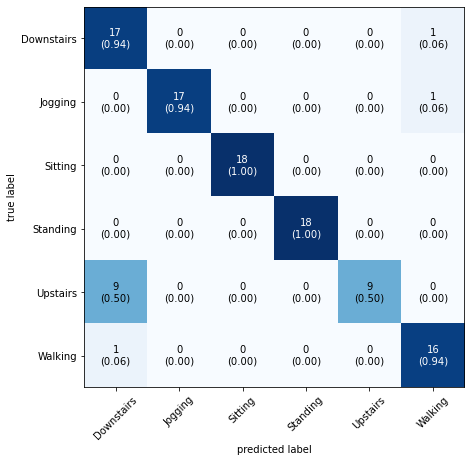

In [37]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))